Preparing data for deep learning models.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run nnn/ipynb_init.py
import explore_fig as ef

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


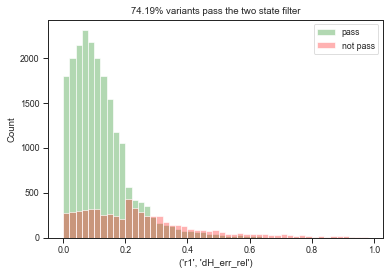

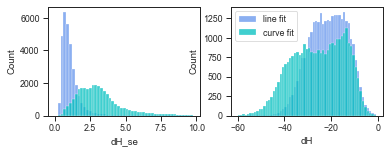

In [2]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.083)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file)

myfilter = "dH_err_rel < 0.2 & Tm_err_abs < 2 & redchi < 1.5 & n_inlier > 10"
pass_df = arraydata.filter_two_state(min_rep_pass=2, force_recalculate=True, overwrite_dH=False, 
                                     inplace=True, myfilter=myfilter)

variant_filter = 'Tm < 55 & Tm > 25'
arr = arraydata.data.join(arraydata.annotation).query(variant_filter)
arraydata.accounting_df.loc['Tm_in_range', :] = arr.groupby('Series').apply(len)
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

<AxesSubplot:xlabel='Number of variant', ylabel='Series'>

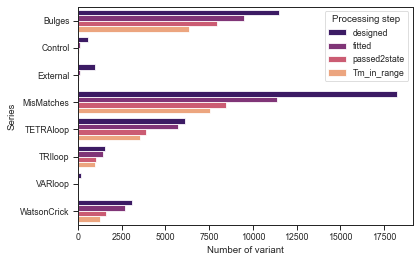

In [216]:
df = arraydata.accounting_df.stack().to_frame('Number of variant').reset_index()
df.rename(columns={'level_0':'Processing step', 'level_1':'Series'}, inplace=True)
sns.barplot(data=df, y='Series', x='Number of variant', hue='Processing step', palette='magma')

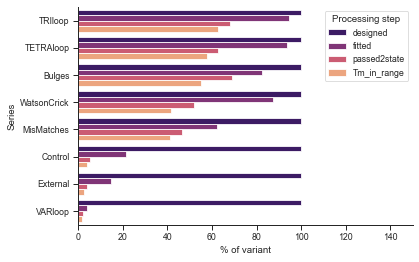

In [217]:
accounting_norm_df = arraydata.accounting_df / arraydata.accounting_df.loc['designed', :] * 100
accounting_norm_df.sort_values(axis=1, by='Tm_in_range', inplace=True, ascending=False)
df = accounting_norm_df.stack().to_frame('% of variant').reset_index()
df.rename(columns={'level_0':'Processing step', 'level_1':'Series'}, inplace=True)
sns.barplot(data=df, y='Series', x='% of variant', hue='Processing step', palette='magma')
plt.xlim([0,150])
sns.despine()

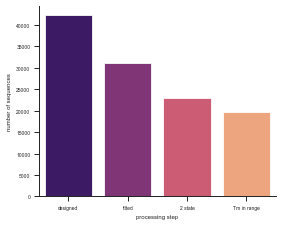

In [ ]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
sns.barplot(data=arraydata.accounting_df.sum(axis=1).reset_index(), x='index', y=0, 
            palette='magma')
plt.ylabel('number of sequences', size=label_font_size)
plt.xlabel('processing step', size=label_font_size)
ax.set_xticklabels(['designed', 'fitted', '2 state', 'Tm in range'])
ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
sns.despine()
util.save_fig('./fig/accounting/processing_steps.pdf')

In [274]:
# Cleaning data for DL
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType'])
arr.to_csv('./data/models/arr_clean_220818.csv')

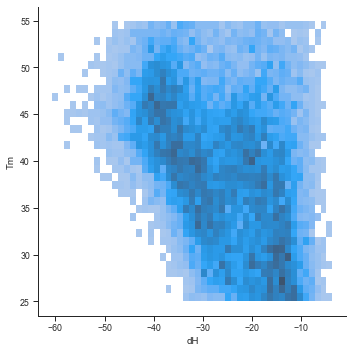

In [249]:
sns.displot(data=arr, x='dH', y='Tm')
# plt.xscale('symlog')TargetStruct

In [284]:
from sklearn.model_selection import train_test_split

train_val_ind, test_ind = train_test_split(arr.index, test_size=.2,
                                       random_state=42, stratify=arr.Series)
train_ind, val_ind = train_test_split(arr.loc[train_val_ind,:].index, test_size=.2,
                                      random_state=43, stratify=arr.loc[train_val_ind,:].Series)
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())
with open('./data/models/train_val_test_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

12604 3152 3940


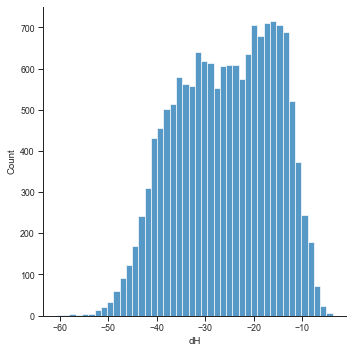

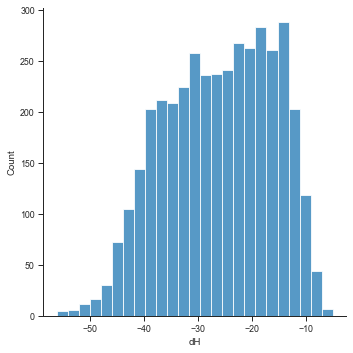

In [257]:
sns.displot(data=arr.loc[train_ind,:], x='dH')
sns.displot(data=arr.loc[test_ind,:], x='dH')

In [73]:
np.random.seed(99)
train_ind_sample = np.random.choice(train_ind, 1500, replace=False)
test_ind_sample = np.random.choice(test_ind, 500, replace=False)

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from Levenshtein import *
from tqdm import tqdm

In [74]:
train_distance = np.zeros((n_train, n_train))
test_distance = np.zeros((n_test, n_train))

for i,seq_i in tqdm(enumerate(arr.loc[train_ind_sample].RefSeq)):
    for j in range(i):
        seq_j = arr.loc[train_ind_sample].iloc[j,:].RefSeq
        train_distance[i,j] = distance(seq_i, seq_j)

1500it [13:35,  1.84it/s]


In [84]:
# test_distance_sample = np.zeros((500, 1500))
for i,seq_i in tqdm(enumerate(arr.loc[test_ind_sample].RefSeq)):
    for j in range(i, 1500):
        seq_j = arr.loc[train_ind_sample].iloc[j,:].RefSeq
        test_distance_sample[i,j] = distance(seq_i, seq_j)

500it [07:38,  1.09it/s]


In [90]:
# train_distance_sample = train_distance[:1500, :1500]
np.save('./data/models/knn/train_distance_sample.npy', train_distance_sample)


In [82]:
np.save('./data/models/knn/test_distance_sample.npy', test_distance_sample)


In [11]:
with open('./data/models/archive/train_test_split_old.json', 'r') as fh:
    old_split = json.load(fh)
    
train_ind_sample, test_ind_sample = old_split['train_ind_sample'], old_split['test_ind_sample']

In [57]:
test_distance_sample.shape

(500, 1500)

In [17]:
train_distance_sample = np.load('./data/models/knn/train_distance_sample.npy')
test_distance_sample = np.load('./data/models/knn/test_distance_sample.npy')

In [62]:
neigh = KNeighborsRegressor(n_neighbors=1, metric='precomputed', weights='uniform')
y = arr.loc[train_ind_sample, ['dH', 'Tm']]
neigh.fit(np.zeros_like(train_distance_sample), y.values)
y_pred_test = neigh.predict(test_distance_sample)
# y_pred_test

In [63]:
y_test = arr.loc[test_ind_sample, ['dH', 'Tm']]
# test_df = pd.concat((y_test, pd.DataFrame(y_pred_test, columns=['dH_pred', 'Tm_pred'])), axis=1, ignore_index=True)
test_df = pd.DataFrame(data=np.concatenate((y_test.values, y_pred_test), axis=1),
                       index=y_test.index,
                       columns=['dH', 'Tm', 'dH_pred', 'Tm_pred'])

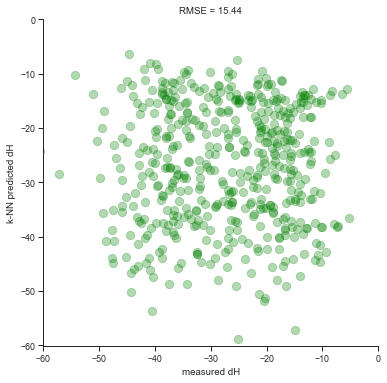

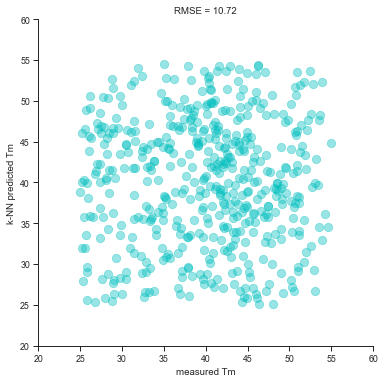

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.scatter(y_test.iloc[:,0], y_pred_test[:,0], 
            s=70, c='g', alpha=0.3)
ax.set_ylim([-60, 0])
ax.set_xlim([-60, 0])
ax.set_xlabel('measured dH')
ax.set_ylabel('k-NN predicted dH')
rmse = np.sqrt(np.sum((y_test.iloc[:,0] - y_pred_test[:,0])**2) / 500)
ax.set_title('RMSE = %.2f' % rmse)
sns.despine()
util.save_fig('./fig/models/knn/dH_15neigh_sample_test.pdf')

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(y_test.iloc[:,1], y_pred_test[:,1], 
            s=70, c='c', alpha=0.4)
ax.set_ylim([20, 60])
ax.set_xlim([20, 60])
ax.set_xlabel('measured Tm')
ax.set_ylabel('k-NN predicted Tm')
rmse = np.sqrt(np.sum((y_test.iloc[:,1] - y_pred_test[:,1])**2) / 500)
ax.set_title('RMSE = %.2f' % rmse)
sns.despine()
util.save_fig('./fig/models/knn/Tm_15neigh_sample_test.pdf')

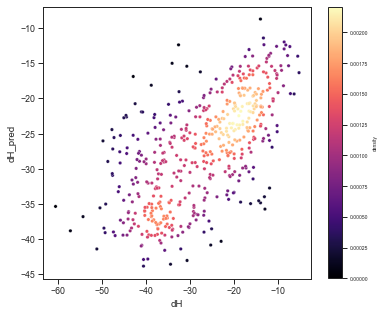

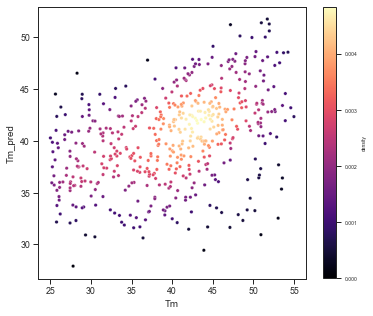

In [116]:
plotting.plot_colored_scatter_comparison(data=test_df, x='dH', y='dH_pred', palette='magma')
plotting.plot_colored_scatter_comparison(data=test_df, x='Tm', y='Tm_pred', palette='magma')

In [89]:
train_distance_sample = train_distance_sample + train_distance_sample.T - np.diag(np.diag(train_distance_sample))


In [278]:
split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())

with open('./data/models/train_val_test_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

In [7]:
arr, data_split_dict = fileio.read_ml_data('./data/models/')

# Test knn.py

In [9]:
from src.models.knn import *

In [14]:
test_distance = compute_edit_distance(['ABCD', 'A'], ['ABCD', 'ABCE'])

1it [00:00, 9915.61it/s]


In [15]:
test_distance

array([[0, 1]])

In [19]:
distance = np.load('./data/models/processed/distance_mat_val_train_seq.npy')
distance.shape

(39727808,)

In [53]:
knn_result = pd.read_csv('./data/models/knn_out/knn_rmse.csv', header=None)
knn_result.columns = ['mode', 'k', 'has_struct', 'combine', 'dH_rmse', 'Tm_rmse']
knn_result['mean_rmse'] = (knn_result.dH_rmse + knn_result.Tm_rmse) / 2

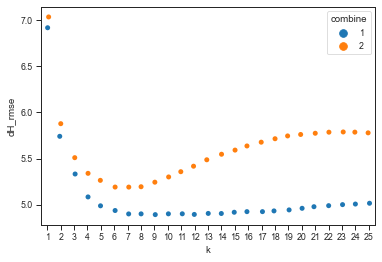

<AxesSubplot:xlabel='k', ylabel='Tm_rmse'>

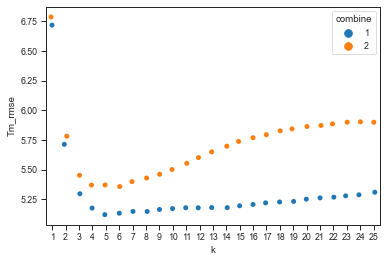

In [30]:
sns.stripplot(data=knn_result.query('has_struct'), x='k', y='dH_rmse', hue='combine')
plt.show()
sns.stripplot(data=knn_result.query('has_struct'), x='k', y='Tm_rmse', hue='combine')

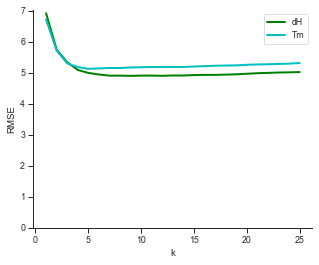

In [50]:
fig, ax = plt.subplots(figsize=(5,4))
sns.lineplot(data=knn_result.query('has_struct & combine == 1'), x='k', y='dH_rmse', color='g', linewidth=2, label='dH')
sns.lineplot(data=knn_result.query('has_struct & combine == 1'), x='k', y='Tm_rmse', color='c', linewidth=2, label='Tm')
ax.set_ylabel('RMSE')
plt.ylim(bottom=0)
# plt.legend(['dH', 'Tm'])
plt.legend()
sns.despine()
util.save_fig('./fig/models/knn/knn_RMSE_as_a_function_of_k.pdf')

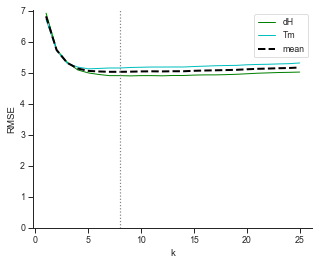

In [73]:
fig, ax = plt.subplots(figsize=(5,4))
sns.lineplot(data=knn_result.query('has_struct & combine == 1'), x='k', y='dH_rmse', color='g', linewidth=1, label='dH')
sns.lineplot(data=knn_result.query('has_struct & combine == 1'), x='k', y='Tm_rmse', color='c', linewidth=1, label='Tm')
sns.lineplot(data=knn_result.query('has_struct & combine == 1'), x='k', y='mean_rmse', color='k', linestyle='--', linewidth=2, label='mean')
ax.axvline(x=8, c='gray', linestyle=':')
ax.set_ylabel('RMSE')
plt.ylim(bottom=0)
# plt.legend(['dH', 'Tm'])
plt.legend()
sns.despine()
util.save_fig('./fig/models/knn/knn_RMSE_as_a_function_of_k.pdf')

In [66]:
np.argmin(knn_result.query('has_struct & combine == 1').sort_values(by='k').mean_rmse)

6

In [70]:
knn_result.query('has_struct & combine == 1').sort_values(by='k')

,mode,k,has_struct,combine,dH_rmse,Tm_rmse,mean_rmse
3,train,1,True,1,6.917756,6.716957,6.817357
4,train,2,True,1,5.742137,5.713897,5.728017
5,train,3,True,1,5.334093,5.297938,5.316016
6,train,4,True,1,5.085843,5.177344,5.131594
2,train,5,True,1,4.989602,5.122291,5.055947
7,train,6,True,1,4.938762,5.134308,5.036535
8,train,7,True,1,4.901845,5.149128,5.025487
9,train,8,True,1,4.902393,5.148603,5.025498
10,train,9,True,1,4.894298,5.165460,5.029879
11,train,10,True,1,4.902830,5.173110,5.037970


We picked k=8, with structure information, and L1 addition!

# Plot NUPACK baseline

In [12]:
arr, data_split_dict = fileio.read_ml_data('./data/models/raw')

In [79]:
arr['data_split'] = ''
arr.loc[data_split_dict['train_ind'], 'data_split'] = 'train'
arr.loc[data_split_dict['val_ind'], 'data_split'] = 'val'
arr.loc[data_split_dict['test_ind'], 'data_split'] = 'test'

In [82]:
arr.columns

Index(['dH', 'dH_se', 'dH_lb', 'dH_ub', 'Tm', 'Tm_se', 'Tm_lb', 'Tm_ub',
       'dG_37', 'dG_37_se', 'dG_37_lb', 'dG_37_ub', 'dS', 'dS_se', 'dS_lb',
       'dS_ub', 'fmax', 'fmax_se', 'fmax_lb', 'fmax_ub', 'fmin', 'fmin_se',
       'fmin_lb', 'fmin_ub', 'two_state', 'dH_line', 'dH_se_line', 'Series',
       'ConstructType', 'bottomScaffold', 'topScaffold', 'RefSeq', 'dH_NUPACK',
       'dS_NUPACK', 'Tm_NUPACK', 'dG_37_ensemble_NUPACK', 'TargetStruct',
       'dG_37_NUPACK', 'dG_37_ensemble_150mM_NUPACK',
       'dG_37_ensemble_75mM_NUPACK', 'GC', 'Tm_NUPACK_salt_corrected',
       'dG_37_NUPACK_salt_corrected', 'dH_NUPACK_salt_corrected',
       'dS_NUPACK_salt_corrected', 'scaffold', 'data_split'],
      dtype='object')

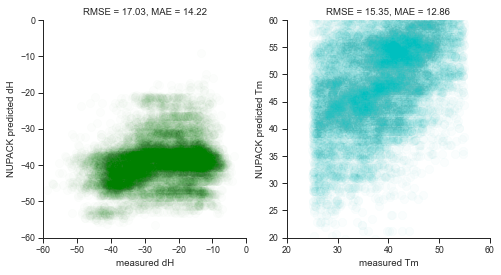

In [91]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1 - y2)))
def mae(y1, y2):
    return np.mean(np.abs(y1 - y2))

data_split = 'train'
df = arr.query('data_split == "%s"' % data_split)
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(df['dH'], df['dH_NUPACK_salt_corrected'], 
              s=70, c='g', alpha=0.01)
dH_rmse = rmse(df['dH'], df['dH_NUPACK_salt_corrected'])
dH_mae = mae(df['dH'], df['dH_NUPACK_salt_corrected'])
ax[0].set_ylim([-60, 0])
ax[0].set_xlim([-60, 0])
ax[0].set_xlabel('measured dH')
ax[0].set_ylabel('NUPACK predicted dH')
ax[0].set_title('RMSE = %.2f, MAE = %.2f' % (dH_rmse, dH_mae))
sns.despine()

ax[1].scatter(df['Tm'], df['Tm_NUPACK_salt_corrected'], 
              s=70, c='c', alpha=0.02)
Tm_rmse = rmse(df['Tm'], df['Tm_NUPACK_salt_corrected'])
Tm_mae = mae(df['Tm'], df['Tm_NUPACK_salt_corrected'])
ax[1].set_ylim([20, 60])
ax[1].set_xlim([20, 60])
ax[1].set_xlabel('measured Tm')
ax[1].set_ylabel('NUPACK predicted Tm')
ax[1].set_title('RMSE = %.2f, MAE = %.2f' % (Tm_rmse, Tm_mae))
sns.despine()
util.save_fig('./fig/models/NUPACK/NUPACK_%s.pdf'%data_split)

In [94]:
print(len(data_split_dict['train_ind']),
      len(data_split_dict['val_ind']),
      len(data_split_dict['test_ind']))

12604 3152 3940


In [99]:
12604 + 3152 + 3940

19696

In [105]:
arraydata.accounting_df.sum(axis=1)

designed        42241.0
fitted          30998.0
passed2state    23000.0
Tm_in_range     19738.0
dtype: float64

In [106]:
19696 / 42241

0.46627684003693093

In [110]:
arr.dH_se.median()

2.4861802454040234

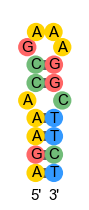

In [25]:
draw_struct(arr.iloc[1,:].RefSeq, arr.iloc[1,:].TargetStruct)

In [16]:
 arr.iloc[1,:].RefSeq

'AGAAACCGAAAGGCTTCT'

In [9]:
def dotbracket2edgelist(dotbracket_str:str, 
                        edge_feature:bool=True):
    
    assert isinstance(dotbracket_str, str), f'{dotbracket_str} is not a string'
    assert dotbracket_str.count('(') == dotbracket_str.count(')'), \
        'Number of "(" and ")" should match in %s' % dotbracket_str

    # Backbone edges
    N = len(dotbracket_str)
    edge_5p_list = [[i, i+1] for i in range(N-1)]

    # Hydrogen bonds
    edge_hbond_list = []
    flag3p = N - 1
    for i,x in enumerate(dotbracket_str):
        if x == '(':
            for j in range(flag3p, i, -1):
                if dotbracket_str[j] == ')':
                    edge_hbond_list.append([i, j])
                    flag3p = j - 1
                    break

    # 5to3, 3to5, bidirectional hbond
    edge_list = edge_5p_list + [e[::-1] for e in edge_5p_list] + edge_hbond_list + [e[::-1] for e in edge_hbond_list]
    
    if edge_feature:
        n_backbone, n_hbond = len(edge_5p_list), len(edge_hbond_list)
        edge_attr = np.zeros((len(edge_list), 3), dtype=int)
        edge_attr[:n_backbone, 0] = 1
        edge_attr[n_backbone:n_backbone*2, 1] = 1
        edge_attr[-2 * n_hbond:, 2] = 1
        return edge_list, edge_attr
    else:
        return edge_list


def onehot_nucleotide(seq_str):
    map_dict = dict(A=0, T=1, C=2, G=3)
    N = len(seq_str)
    encode_arr = np.zeros((N, 4))
    for i,x in enumerate(seq_str.upper()):
        encode_arr[i, map_dict[x]] = 1
    return encode_arr

def norm_dH(dH):
    return (dH + 26) / 10

def unorm_dH(dH_norm):
    return dH_norm * 10 - 26

def norm_Tm(Tm):
    return (Tm - 40) / 7.5

def unorm_Tm(Tm_norm):
    return Tm_norm * 7.5 + 40

def row2graphdata(row):
    edge_list, edge_feat = dotbracket2edgelist(row['TargetStruct'])
    edge_index = torch.tensor(np.array(edge_list).T, dtype=torch.long) #int64
    edge_attr = torch.tensor(edge_feat, dtype=torch.float)
    x = torch.tensor(onehot_nucleotide(row['RefSeq']), dtype=torch.float)
    y = torch.tensor([norm_dH(row['dH']), norm_Tm(row['Tm'])], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

assert np.allclose(onehot_nucleotide('AT'), np.array([[1, 0, 0, 0], [0, 1, 0, 0]]))

In [11]:
dotbracket2edgelist(arr.iloc[0,:].TargetStruct)

([[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [11, 12],
  [12, 13],
  [13, 14],
  [14, 15],
  [1, 0],
  [2, 1],
  [3, 2],
  [4, 3],
  [5, 4],
  [6, 5],
  [7, 6],
  [8, 7],
  [9, 8],
  [10, 9],
  [11, 10],
  [12, 11],
  [13, 12],
  [14, 13],
  [15, 14],
  [0, 15],
  [1, 14],
  [2, 13],
  [3, 12],
  [4, 11],
  [5, 10],
  [15, 0],
  [14, 1],
  [13, 2],
  [12, 3],
  [11, 4],
  [10, 5]],
 array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1

In [14]:

for key in data_split_dict:
    print(len(data_split_dict[key]))

12604
3152
3940


In [24]:
row1, row2 = arr.iloc[0,:], arr.iloc[1,:]
distance(row1.RefSeq, row2.RefSeq), distance(row1.TargetStruct, row2.TargetStruct)

(8, 2)

In [21]:
from tqdm import tqdm
from Levenshtein import distance